In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_singlegrid_one'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 31 x 91


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f841c50d630> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f841c504c18>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.71 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.712    |
| time/              |          |
|    fps             | 118      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 54 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.693      |
| time/                   |            |
|    fps                  | 344        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |       

policy iteration runtime: 41 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.727       |
| time/                   |             |
|    fps                  | 355         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.050451618 |
|    clip_fraction        | 0.502       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.97        |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0394     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0475     |
|    std                  | 0.182       |
|    val

policy iteration runtime: 38 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.748      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04893533 |
|    clip_fraction        | 0.518      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.21       |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0673    |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0457    |
|    std                  | 0.18       |
|    v

policy iteration runtime: 38 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.756       |
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.050450385 |
|    clip_fraction        | 0.542       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.41        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0624     |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0441     |
|    std                  | 0.178       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 354         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.053066384 |
|    clip_fraction        | 0.546       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.6         |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0273     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0437     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.782      |
| time/                   |            |
|    fps                  | 358        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06875864 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.99       |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0148    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0407    |
|    std                  | 0.174      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.793       |
| time/                   |             |
|    fps                  | 351         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.071524516 |
|    clip_fraction        | 0.581       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.41        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0578     |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.038      |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.804      |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08456362 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.93       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0867    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0374    |
|    std                  | 0.166      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.808       |
| time/                   |             |
|    fps                  | 349         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.077472925 |
|    clip_fraction        | 0.59        |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.49        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0638     |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0309     |
|    std                  |

policy iteration runtime: 29 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.816      |
| time/                   |            |
|    fps                  | 353        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08389551 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.91       |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0163     |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0303    |
|    std                  | 0.159      |
|    

policy iteration runtime: 29 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.821      |
| time/                   |            |
|    fps                  | 350        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07148434 |
|    clip_fraction        | 0.605      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.35       |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0428    |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0282    |
|    std                  | 0.156      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08291142 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.76       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0422    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0256    |
|    std                  | 0.153      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.836       |
| time/                   |             |
|    fps                  | 351         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.081381276 |
|    clip_fraction        | 0.634       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0901     |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0269     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.841      |
| time/                   |            |
|    fps                  | 347        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07699802 |
|    clip_fraction        | 0.614      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.7       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0334    |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0253    |
|    std                  | 0.147      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08685829 |
|    clip_fraction        | 0.626      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.2       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00321    |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0205    |
|    std                  | 0.143      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.844       |
| time/                   |             |
|    fps                  | 347         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.090858996 |
|    clip_fraction        | 0.629       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.6        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.072      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0227     |
|    std                  |

policy iteration runtime: 28 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08404767 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0399    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0184    |
|    std                  | 0.139      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 354        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08795446 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.2       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00105    |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0178    |
|    std                  | 0.137      |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.848       |
| time/                   |             |
|    fps                  | 360         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.112970926 |
|    clip_fraction        | 0.655       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.6        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0191     |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0185     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 78336

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.848      |
| time/                   |            |
|    fps                  | 355        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11615505 |
|    clip_fraction        | 0.649      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0115    |
|    n_updates            | 3060       |
|    policy_gradient_loss | -0.0214    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 82432

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.85     |
| time/                   |          |
|    fps                  | 352      |
|    iterations           | 1        |
|    time_elapsed         | 7        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.116199 |
|    clip_fraction        | 0.662    |
|    clip_range           | 0.15     |
|    entropy_loss         | 13.2     |
|    explained_variance   | 0.983    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.0276  |
|    n_updates            | 3220     |
|    policy_gradient_loss | -0.0211  |
|    std                  | 0.131    |
|    value_loss           | 0.00106  |
------

policy iteration runtime: 36 seconds

Total episode rollouts: 86528

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 340        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11520903 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0462    |
|    n_updates            | 3380       |
|    policy_gradient_loss | -0.0204    |
|    std                  | 0.129      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 90624

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 350        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14176074 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0882    |
|    n_updates            | 3540       |
|    policy_gradient_loss | -0.0199    |
|    std                  | 0.127      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 94720

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12113035 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00446   |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0138    |
|    std                  | 0.124      |
|    value_loss           |

Early stopping at step 18 due to reaching max kl: 0.17
policy iteration runtime: 35 seconds

Total episode rollouts: 98816

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16941532 |
|    clip_fraction        | 0.683      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0521    |
|    n_updates            | 3860       |
|    policy_gradient_loss | -0.0167    |
|    std     

policy iteration runtime: 36 seconds

Total episode rollouts: 102912

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13008203 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0289     |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.0174    |
|    std                  | 0.122      |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 107008

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11688831 |
|    clip_fraction        | 0.684      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0128    |
|    n_updates            | 4180       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 111104

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 352        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14420123 |
|    clip_fraction        | 0.692      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0736    |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.119      |
|    value_loss           

policy iteration runtime: 34 seconds

Total episode rollouts: 115200

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 352        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13247211 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0647    |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.119      |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 119296

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 350        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13661158 |
|    clip_fraction        | 0.698      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0315     |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.0124    |
|    std                  | 0.118      |
|    value_loss           

Early stopping at step 12 due to reaching max kl: 0.15
policy iteration runtime: 26 seconds

Total episode rollouts: 123392

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15366077 |
|    clip_fraction        | 0.666      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0562    |
|    n_updates            | 4820       |
|    policy_gradient_loss | -0.000545  |
|    std    

policy iteration runtime: 31 seconds

Total episode rollouts: 127488

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13369918 |
|    clip_fraction        | 0.689      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0335    |
|    n_updates            | 4980       |
|    policy_gradient_loss | -0.00894   |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 131584

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15119457 |
|    clip_fraction        | 0.68       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0518     |
|    n_updates            | 5140       |
|    policy_gradient_loss | -0.00821   |
|    std    

Early stopping at step 10 due to reaching max kl: 0.15
policy iteration runtime: 23 seconds

Total episode rollouts: 135680

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 348        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15396756 |
|    clip_fraction        | 0.693      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0928     |
|    n_updates            | 5300       |
|    policy_gradient_loss | 0.000829   |
|    std    

Early stopping at step 11 due to reaching max kl: 0.15
policy iteration runtime: 25 seconds

Total episode rollouts: 139776

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 353        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15433545 |
|    clip_fraction        | 0.683      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0255     |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.00168   |
|    std    

Early stopping at step 11 due to reaching max kl: 0.16
policy iteration runtime: 25 seconds

Total episode rollouts: 143872

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 349       |
|    iterations           | 1         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1641707 |
|    clip_fraction        | 0.675     |
|    clip_range           | 0.15      |
|    entropy_loss         | 16        |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0374   |
|    n_updates            | 5620      |
|    policy_gradient_loss | 0.00261   |
|    std                  | 0.1

Early stopping at step 12 due to reaching max kl: 0.17
policy iteration runtime: 26 seconds

Total episode rollouts: 147968

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 347        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16694845 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0355    |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.00626   |
|    std    

<IPython.core.display.Javascript object>


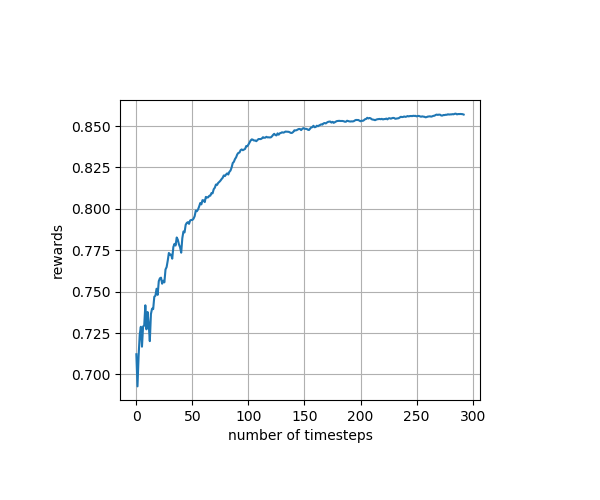

Using cuda device
seed 2: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 31 x 91


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f841c50cac8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f841c4f9278>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.694      |
| time/                   |            |
|    fps                  | 120        |
|    iterations           | 1          |
|    time_elapsed         | 21         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15500809 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00912   |
|    n_updates            | 5860       |
|    policy_gradient_loss | 0.00187    |
|    std                  | 0.114      |
|    value_loss           | 0.000941   |
---------------------------------

policy iteration runtime: 36 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.73       |
| time/                   |            |
|    fps                  | 342        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05311913 |
|    clip_fraction        | 0.49       |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.14       |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0768    |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0448    |
|    std                  | 0.181      |
|    v

policy iteration runtime: 36 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.766       |
| time/                   |             |
|    fps                  | 343         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.060507365 |
|    clip_fraction        | 0.513       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.37        |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0378     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0457     |
|    std                  | 

policy iteration runtime: 36 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.774       |
| time/                   |             |
|    fps                  | 349         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.050460957 |
|    clip_fraction        | 0.538       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.6         |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0104      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0459     |
|    std                  | 0.177       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.78       |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05226881 |
|    clip_fraction        | 0.554      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.97       |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0907    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0437    |
|    std                  | 0.174      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.789      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06886627 |
|    clip_fraction        | 0.57       |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.47       |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0422    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0436    |
|    std                  | 0.17       |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.803      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07467415 |
|    clip_fraction        | 0.58       |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.98       |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.104     |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0349    |
|    std                  | 0.166      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.811       |
| time/                   |             |
|    fps                  | 344         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.080256805 |
|    clip_fraction        | 0.584       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.62        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0135     |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.034      |
|    std                  | 0.161       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.825       |
| time/                   |             |
|    fps                  | 343         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083945714 |
|    clip_fraction        | 0.59        |
|    clip_range           | 0.15        |
|    entropy_loss         | 9.02        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0425     |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0298     |
|    std                  |

policy iteration runtime: 31 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.829      |
| time/                   |            |
|    fps                  | 359        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06726808 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.22       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0688    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0305    |
|    std                  | 0.157      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 347        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07152999 |
|    clip_fraction        | 0.598      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.63       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.01      |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0255    |
|    std                  | 0.154      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.843      |
| time/                   |            |
|    fps                  | 340        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07089133 |
|    clip_fraction        | 0.604      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.2       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0276    |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.151      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.846     |
| time/                   |           |
|    fps                  | 343       |
|    iterations           | 1         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0813032 |
|    clip_fraction        | 0.606     |
|    clip_range           | 0.15      |
|    entropy_loss         | 10.6      |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0262   |
|    n_updates            | 1920      |
|    policy_gradient_loss | -0.022    |
|    std                  | 0.148     |
|    value_loss           | 0.00102   |
-------

policy iteration runtime: 39 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 345        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07785465 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.9       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.012      |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.0187    |
|    std                  | 0.146      |
|    

policy iteration runtime: 37 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.851       |
| time/                   |             |
|    fps                  | 338         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.087666236 |
|    clip_fraction        | 0.603       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.3        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00698    |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0195     |
|    std                  | 0.143       |
|    va

policy iteration runtime: 35 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 340        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08799837 |
|    clip_fraction        | 0.618      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.7       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0339    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.015     |
|    std                  | 0.141      |
|    

policy iteration runtime: 30 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08691513 |
|    clip_fraction        | 0.626      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0292     |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0194    |
|    std                  | 0.139      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.856      |
| time/                   |            |
|    fps                  | 342        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11224596 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0643    |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.02      |
|    std                  | 0.137      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09863174 |
|    clip_fraction        | 0.632      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.6       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.018      |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0206    |
|    std                  | 0.136      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.857       |
| time/                   |             |
|    fps                  | 341         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088481404 |
|    clip_fraction        | 0.629       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.9        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0314      |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.0146     |
|    std                  | 0.134       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 345        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11708941 |
|    clip_fraction        | 0.645      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0205    |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.0204    |
|    std                  | 0.132      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10216651 |
|    clip_fraction        | 0.634      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.028     |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0167    |
|    std                  | 0.13       |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 347        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09610488 |
|    clip_fraction        | 0.646      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0515    |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.0123    |
|    std                  | 0.129      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10962844 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0335     |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0146    |
|    std                  | 0.127      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11480248 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0506    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0184    |
|    std                  | 0.127      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13385722 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0115     |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.00984   |
|    std                  | 0.125      |
|   

policy iteration runtime: 38 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14054306 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0627    |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.0124    |
|    std                  | 0.125      |
|    value_loss           

policy iteration runtime: 40 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 337        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11502383 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00636   |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.00435   |
|    std                  | 0.125      |
|    value_loss           

policy iteration runtime: 40 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 340        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13176946 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0663    |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.0125    |
|    std                  | 0.123      |
|    value_loss           

policy iteration runtime: 39 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 343        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12934497 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.051      |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.00977   |
|    std                  | 0.123      |
|    value_loss           

policy iteration runtime: 40 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12485744 |
|    clip_fraction        | 0.674      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0331     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.122      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 341        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12345084 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.1       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00225   |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.00826   |
|    std                  | 0.122      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 33 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 339        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16126302 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0358     |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.00916   |
|    std    

policy iteration runtime: 41 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 349        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12677321 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0129    |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.01      |
|    std                  | 0.121      |
|    value_loss           

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.861      |
| time/                   |            |
|    fps                  | 339        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15190056 |
|    clip_fraction        | 0.664      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0537    |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.

policy iteration runtime: 40 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.861      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14547975 |
|    clip_fraction        | 0.679      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0185    |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.0113    |
|    std                  | 0.12       |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 341        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13614103 |
|    clip_fraction        | 0.685      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00462   |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.12       |
|    value_loss           

<IPython.core.display.Javascript object>


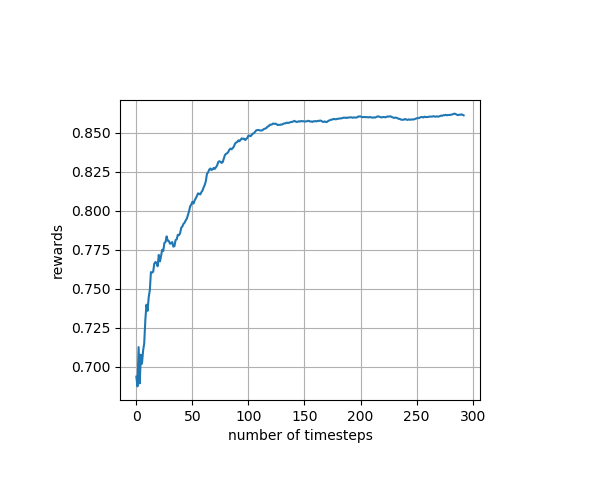

Using cuda device
seed 3: grid fidelity factor 1.0 learning ..
environement grid size (nx x ny ): 31 x 91


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f841c97e978> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f83fc09a860>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.695      |
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 1          |
|    time_elapsed         | 24         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15267739 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0198     |
|    n_updates            | 5860       |
|    policy_gradient_loss | 0.00503    |
|    std                  | 0.119      |
|    value_loss           | 0.000915   |
---------------------------------

policy iteration runtime: 38 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.719       |
| time/                   |             |
|    fps                  | 334         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.048002683 |
|    clip_fraction        | 0.496       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.98        |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.081      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0472     |
|    std                  | 0.182       |
|    val

policy iteration runtime: 38 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.75 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.75      |
| time/                   |           |
|    fps                  | 341       |
|    iterations           | 1         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0447653 |
|    clip_fraction        | 0.504     |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.11      |
|    explained_variance   | 0.945     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0864   |
|    n_updates            | 320       |
|    policy_gradient_loss | -0.0445   |
|    std                  | 0.181     |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.767      |
| time/                   |            |
|    fps                  | 329        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06908785 |
|    clip_fraction        | 0.554      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.57       |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0621    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0482    |
|    std                  | 0.177      |
|    

policy iteration runtime: 42 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.779      |
| time/                   |            |
|    fps                  | 314        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05854539 |
|    clip_fraction        | 0.555      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.85       |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0755    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.043     |
|    std                  | 0.175      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.802     |
| time/                   |           |
|    fps                  | 302       |
|    iterations           | 1         |
|    time_elapsed         | 8         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0615013 |
|    clip_fraction        | 0.586     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.19      |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.043    |
|    n_updates            | 800       |
|    policy_gradient_loss | -0.0433   |
|    std                  | 0.172     |
|    value_loss          

policy iteration runtime: 40 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.805       |
| time/                   |             |
|    fps                  | 304         |
|    iterations           | 1           |
|    time_elapsed         | 8           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.079915926 |
|    clip_fraction        | 0.568       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.78        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0179      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0325     |
|    std                  | 0.168       |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.819      |
| time/                   |            |
|    fps                  | 294        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08251905 |
|    clip_fraction        | 0.603      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.14       |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0226    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0329    |
|    std                  | 0.165      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 292        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07314037 |
|    clip_fraction        | 0.594      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.62       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0628    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0292    |
|    std                  | 0.161      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 290        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06947287 |
|    clip_fraction        | 0.583      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.04       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00979   |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0184    |
|    std                  | 0.159      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.841       |
| time/                   |             |
|    fps                  | 294         |
|    iterations           | 1           |
|    time_elapsed         | 8           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.077872485 |
|    clip_fraction        | 0.594       |
|    clip_range           | 0.15        |
|    entropy_loss         | 9.51        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0131     |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0228     |
|    std                  |

policy iteration runtime: 31 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07861051 |
|    clip_fraction        | 0.598      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.93       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0105     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0217    |
|    std                  | 0.153      |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.848       |
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 1           |
|    time_elapsed         | 8           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.080983266 |
|    clip_fraction        | 0.598       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.3        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0418     |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0225     |
|    std                  | 0.15        |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 289        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08252235 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0238     |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.147      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08192541 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11         |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0337    |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0174    |
|    std                  | 0.145      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10491691 |
|    clip_fraction        | 0.618      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.7       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00667    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0172    |
|    std                  | 0.141      |
|    value_loss           |

policy iteration runtime: 38 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 287        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09504548 |
|    clip_fraction        | 0.624      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12         |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0304     |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0105    |
|    std                  | 0.139      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08740522 |
|    clip_fraction        | 0.616      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.063     |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.137      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 278        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12318649 |
|    clip_fraction        | 0.639      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.6       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0599    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0174    |
|    std                  | 0.135      |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.857      |
| time/                   |            |
|    fps                  | 276        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11712805 |
|    clip_fraction        | 0.632      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.7       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0707    |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.0117    |
|    std                  | 0.134      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.858      |
| time/                   |            |
|    fps                  | 283        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12118907 |
|    clip_fraction        | 0.645      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0172    |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.0191    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.859       |
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 1           |
|    time_elapsed         | 8           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.102438405 |
|    clip_fraction        | 0.629       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.1        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0824     |
|    n_updates            | 3360        |
|    policy_gradient_loss | -0.00891    |
|    std                  | 0.132       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.86      |
| time/                   |           |
|    fps                  | 284       |
|    iterations           | 1         |
|    time_elapsed         | 9         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1079758 |
|    clip_fraction        | 0.631     |
|    clip_range           | 0.15      |
|    entropy_loss         | 13.3      |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.105     |
|    n_updates            | 3520      |
|    policy_gradient_loss | -0.014    |
|    std                  | 0.131     |
|    value_loss          

policy iteration runtime: 38 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13709593 |
|    clip_fraction        | 0.655      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0391    |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0157    |
|    std                  | 0.13       |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.862     |
| time/                   |           |
|    fps                  | 281       |
|    iterations           | 1         |
|    time_elapsed         | 9         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1413872 |
|    clip_fraction        | 0.645     |
|    clip_range           | 0.15      |
|    entropy_loss         | 13.8      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0384   |
|    n_updates            | 3840      |
|    policy_gradient_loss | -0.00969  |
|    std                  | 0.128     |
|    value_loss          

policy iteration runtime: 32 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.861      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14058629 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0407    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0148    |
|    std                  | 0.127      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 290        |
|    iterations           | 1          |
|    time_elapsed         | 8          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12632371 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0364    |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.0106    |
|    std                  | 0.127      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11373003 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00697   |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.0137    |
|    std                  | 0.127      |
|    value_loss           

policy iteration runtime: 40 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 272        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09804313 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0208    |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.00586   |
|    std                  | 0.126      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.862       |
| time/                   |             |
|    fps                  | 274         |
|    iterations           | 1           |
|    time_elapsed         | 9           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.114845894 |
|    clip_fraction        | 0.657       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.4        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0219     |
|    n_updates            | 4640        |
|    policy_gradient_loss | -0.00546    |
|    std                  | 0.125       |
|    v

policy iteration runtime: 38 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.863       |
| time/                   |             |
|    fps                  | 274         |
|    iterations           | 1           |
|    time_elapsed         | 9           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.108655766 |
|    clip_fraction        | 0.665       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.7        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0275      |
|    n_updates            | 4800        |
|    policy_gradient_loss | -0.00772    |
|    std                  | 0.123       |
|    v

policy iteration runtime: 36 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 275        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12285318 |
|    clip_fraction        | 0.668      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0443    |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.00571   |
|    std                  | 0.123      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.862      |
| time/                   |            |
|    fps                  | 272        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12910073 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0368     |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.0027    |
|    std                  | 0.123      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.863      |
| time/                   |            |
|    fps                  | 270        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11613701 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00739   |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.00424   |
|    std                  | 0.124      |
|    value_loss           

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 34 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.864      |
| time/                   |            |
|    fps                  | 264        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15683822 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0691    |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.

Early stopping at step 19 due to reaching max kl: 0.15
policy iteration runtime: 36 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.864      |
| time/                   |            |
|    fps                  | 265        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15287805 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0731    |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.00749   |
|    std    

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 33 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.864      |
| time/                   |            |
|    fps                  | 270        |
|    iterations           | 1          |
|    time_elapsed         | 9          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15095328 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00225    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.00261   |
|    std    

<IPython.core.display.Javascript object>


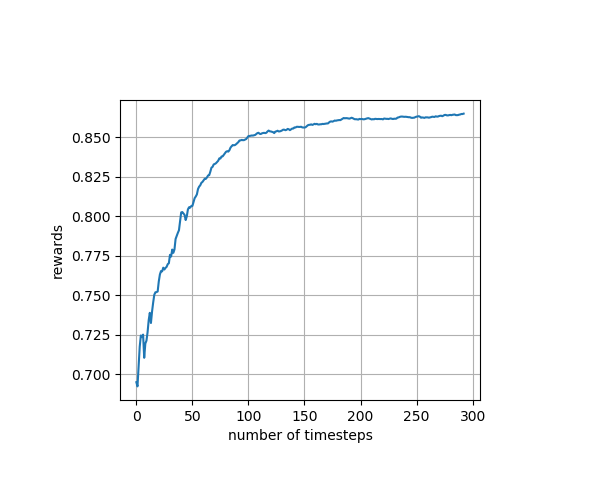

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.3, 
                                n=np.inf,
                                grid_fidelity_factor_array =[1.0],
                                episode_limit_array=[150000], 
                                log_dir=log_dir,
                                seed=seed)